# Oxford Man Institute NLP Tutorial 

## 1. Introduction 

There are several ways of performing sentiment classification on a document or article, ranging from word-counts to modern Transformer-based Language Models. In this tutorial we will take you through a range of classification techniques:
- Loughran & McDonald financial sentiment dictionary
- Naive Bayes Classifier
- BERT out of the box
- BERT fine-tuned on general sentiment datasets
- FinBERT 
    - BERT that has been trained on positive and negative financial documents

## 2. Load and analyse the dataset

### Import packages and load dictionaries

In [1]:
import numpy as np
import pandas as pd
import re
import inspect
import csv
import operator
from omi_nlp_tools import mutual_information # function to get mutual information 
# import my_functions

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from collections import defaultdict, Counter

### Load the dataset

In [2]:
# df = pd.read_csv(r'data/kaggle_data.csv')
# df.columns = ['text', 'class']

In [3]:
df = pd.read_csv('data\\FinancialPhraseBank-v1.0\\Sentences_AllAgree.txt',
            encoding = 'ISO-8859-1',on_bad_lines='skip',sep = '.@', names=['text', 'class'])
df.head()

C:\Users\drago\AppData\Local\Temp\ipykernel_20220\3544662773.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('data\\FinancialPhraseBank-v1.0\\Sentences_AllAgree.txt',


,text,class
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive


#### What kind of text are we dealing with?

The Financial PhraseBank was used by Maks and Vossen (2014) in their paper ***"Good Debt or Bad Debt: Detecting Semantic Orientations in Economic Texts"***. The authors scraped the LexisNexis database for news articles about companies on the OMX Helsinki database.

Although very small, the dataset has since been widely used in the financial community to test and deploy domain specific language models.

In [4]:
for cata in ['positive','negative','neutral']:
    cata_df = df[df['class'] == cata]
    cata_lens = cata_df['text'].str.len()
    max_sentence = cata_df[cata_lens == cata_lens.max()]
    with pd.option_context('display.max_colwidth', 500):
        print(f'The longest {cata} sentence is: \n\n', max_sentence['text'], '\n\n')

The longest positive sentence is: 

 831    MANAVIGATOR-September 7 , 2010-Kemira unveils Indian JV with IVRCL Finnish chemicals group Kemira ( HEL : KRA1V ) on Tuesday announced it has inked a deal to form a joint venture in India with local construction firm IVRCL Infrastructure and Projects Ltd ( BOM :530773 ) 
Name: text, dtype: object 


The longest negative sentence is: 

 2116    Finnish Exel Composites , a technology company that designs , manufactures , and markets composite profiles and tubes for various industrial applications , reports its net sales decreased by 0.6 % in the second quarter of 2010 to EUR 19.2 mn from EUR 19.3 mn in the corresponding period in 2009 
Name: text, dtype: object 


The longest neutral sentence is: 

 764    Supported Nokia phones include : N96 , N95-8GB , N95 , N93-N931 , N92 , N85 , N82 , N81 , N80 , N79 , N78 , N77 , N76 , N75 , N73 , N72 , N71 , E90 , E71 , E70 , E66 , E65 , E62 , E61-E61i , E60 , E51 , E50 , Touch Xpress 5800 , 6220 Classic 

#### Data formatting

The dataset we are using has already been cleaned as it is widely used in the field. If you are using your own custom dataset it may be necessary to clean the text of special characters, URLs, user mentions, emojis etc. 

We will add another columns to our dataset that contains a **tokenised version** of the text as this will form the basis of our Naive Bayes classifier.

In [5]:
token_pattern = re.compile(r"(?u)\b\w\w+\b")
df["tokenised_text"] = df.text.apply(lambda x: token_pattern.findall(x))

**Remove the neutral category** so that we are left with a more extreme examples in our dataset.

In [6]:
df = df[df['class'] != 'neutral']
categories = list(set(df['class']))

In [7]:
n_negative = df[df['class']=="negative"].shape[0]
prop_negative = df[df['class']=="negative"].shape[0]/df.shape[0]

print(f"{df.shape[0]} entries in the dataset")
print("{} entries / {:.2%} labelled as negative\n".format(n_negative, prop_negative)) 

873 entries in the dataset
303 entries / 34.71% labelled as negative



#### Data split

In [8]:
train_text, dev_text, test_text = dict(), dict(), dict()

for c_i in categories:
    train_text[c_i], devtest_text = train_test_split(df[df['class']==c_i].tokenised_text,
                                                         train_size=0.7, random_state=123)
    dev_text[c_i], test_text[c_i] = train_test_split(devtest_text,
                                                         train_size=0.5, random_state=123)

Create vocab dict and remove stopwords:

In [9]:
# Create vocab dict
vocab = defaultdict(Counter)
n_text = defaultdict(Counter)

# Create vocabularies
for c_i in categories:
    for text in train_text[c_i]:
        vocab[c_i].update(text)
        n_text[c_i].update(set(text))

# Remove stopwords
stopwords = list()

with open('./data/stopwords.txt', 'r') as fd:
    reader = csv.reader(fd)
    for row in fd:
        stopwords.append(row.replace("\n",""))
        
for c_i in categories:
    for sw in stopwords:
        del vocab[c_i][sw]

#### Inspection of the classes

In [10]:
for c_i in categories:
    print(f"Most common words in {c_i.upper()} class:")
    display(vocab[c_i].most_common(10))
    print()

Most common words in NEGATIVE class:


[('EUR', 174),
 ('mn', 125),
 ('profit', 83),
 ('year', 57),
 ('net', 52),
 ('quarter', 51),
 ('mln', 50),
 ('sales', 50),
 ('2008', 44),
 ('million', 43)]


Most common words in POSITIVE class:


[('EUR', 237),
 ('mn', 157),
 ('profit', 114),
 ('year', 106),
 ('net', 103),
 ('period', 88),
 ('million', 82),
 ('sales', 80),
 ('Finnish', 75),
 ('mln', 71)]

#### Mututal information

Mutual information can help us explain the differences between word distributions. Understanding the features that differentiate a certain category from another can prove very useful for interpretting differences between categories. 

In [11]:
# Calculate the total number of articles in each class, which we will need to calculate mutual information
n_total = dict()
for c_i in categories:
    n_total[c_i] = len(train_text[c_i])

In [12]:
mi_list = sorted([(mutual_information(w, n_text, n_total), w) for w in set(vocab['negative']).union(set(vocab['positive']))], reverse=True)

print('25 overall most informative features:\n\n', [w for mi, w in mi_list][:25])

25 overall most informative features:

 ['fell', 'increased', 'half', '2008', 'nine', 'due', 'EUR', '17', '2007', 'mn', 'quarter', 'eur', 'profit', 'Helsinki', 'first', 'trade', 'prices', 'electronics', '2010', 'excluding', 'items', 'reports', 'negative', 'third', 'order']


## 3. Traditional sentiment analysis

### Loughran & McDonald classifier

Loughran & McDonald released their master dictionary in 2011 in conjunction with their paper “When is a Liability not a Liability? Textual Analysis, Dictionaries, and 10-Ks". The dictionary lists a number of words and includes negative, positive, uncertainty, litigious, strong modal, weak modal, and constraining tags. 

There are several shortcomings to this simplistic approach:

- **Some words don't appear in the dictionary (fall, rise, etc.)**
- **Some words are negative/positive given the context they are written (profit, expenditure, etc.)**
- **Simple counts of words don't necessarily infer the overall sentiment**
    - *Hatred for football has always confused me; there are so many haters who attack the sport, but I have always loved it.* - 3 negative words and 1 positive word.


We have taken the words that have a negative and positive tag for our classifier:

In [13]:
lmdict = np.load('data/LoughranMcDonald_dict.npy', allow_pickle='TRUE').item()
print('Some examples of negative words: ', lmdict['Negative'][:5])
print('Some examples of positive words: ', lmdict['Positive'][:5])

Some examples of negative words:  ['abandon', 'abandoned', 'abandoning', 'abandonment', 'abandonments']
Some examples of positive words:  ['able', 'abundance', 'abundant', 'acclaimed', 'accomplish']


In [14]:
lmdict['Positive'][:5]

['able', 'abundance', 'abundant', 'acclaimed', 'accomplish']

Check to see if a word appears in the dictionary:

In [15]:
word = 'fall'

if word in lmdict['Negative']:
    print(f'Yes, {word} is a Negative word in the Loughran & McDonald dictionary')
elif word in lmdict['Positive']:
    print(f'Yes, {word} is Positive word in the Loughran & McDonald dictionary')
else:
    print(f'No, {word} is not in the Loughran & McDonald dictionary')

No, fall is not in the Loughran & McDonald dictionary


Negation is another challenge that emerges using this approach. A techy fix is to check if the word is preceeded by a negating word in our list:

In [16]:
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

In [17]:
def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

This function counts the number of negative and positive words in a document and performs a negation check to switch the polarity of words that are preceeded by a word in the *negate* list.

In [18]:
def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
 
    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
 
    word_count = len(input_words)
 
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
                
    sentiment_score = len(pos_words) - len(neg_words)
    
    if sentiment_score < 0:
        classification = 'negative'
    elif sentiment_score > 0:
        classification = 'positive'
    else:
        classification = 'neutral'
 
    results = [word_count, pos_count, neg_count, pos_words, neg_words, classification]
 
    return results
 
    
# A sample output
article = '''The stock market has had its worst start to a year in recent history and things could get 
             worse as recession fears loom. Since World War II there have been 13 recessions—defined as 
             two consecutive quarters of GDP decline–and there have been 3 in the 21st century (2001, 2008 and 2020), 
             according to the National Bureau of Economic Research. Some experts say another one could be on the way.'''
 
sent_results = tone_count_with_negation_check(lmdict, article)

print('The results with negation check:', end='\n\n')
print('The # of positive words:', sent_results[1])
print('The # of negative words:', sent_results[2])
print('The list of found positive words:', sent_results[3])
print('The list of found negative words:', sent_results[4])
print('The overall classification is:', sent_results[5])

The results with negation check:

The # of positive words: 0
The # of negative words: 6
The list of found positive words: []
The list of found negative words: ['worst', 'worse', 'recession', 'fears', 'recessions', 'decline']
The overall classification is: negative


Sometimes this technique can be successful, but there are many examples where it falls short. For example, when we use a clearly negative text that doesn't contain any words in the lexicon.

In [19]:
article = '''Pharmaceuticals group Orion Corp reported a fall in its third-quarter earnings that 
             were hit by larger expenditures on R&D and marketing'''
 
sent_results = tone_count_with_negation_check(lmdict, article)

print('The results with negation check:', end='\n\n')
print('The # of positive words:', sent_results[1])
print('The # of negative words:', sent_results[2])
print('The list of found positive words:', sent_results[3])
print('The list of found negative words:', sent_results[4])
print('The overall classification is:', sent_results[5])

The results with negation check:

The # of positive words: 0
The # of negative words: 0
The list of found positive words: []
The list of found negative words: []
The overall classification is: neutral


#### Performance on the Financial PhraseBank dataset

In [20]:
labels = list(df['class'])
predictions= list()

for phrase, c_i in zip(df['text'], df['class']):
    sent_results = tone_count_with_negation_check(lmdict, phrase)
    classification = sent_results[5]
    predictions.append(classification)

In [21]:
neutral_count = predictions.count('neutral')
positive_count = predictions.count('positive')
negative_count = predictions.count('negative')

print(f'We passed {len(predictions)} examples through the LM classifier \n')
print(f'There were {neutral_count} NEUTRAL predictions')
print(f'There were {positive_count} POSITIVE predictions')
print(f'There were {negative_count} NEGATIVE predictions')

We passed 873 examples through the LM classifier 

There were 573 NEUTRAL predictions
There were 101 POSITIVE predictions
There were 199 NEGATIVE predictions


In [22]:
print(classification_report(labels, predictions, digits=3))
print('f1 score : ',f1_score(labels, predictions, average='macro'))

              precision    recall  f1-score   support

    negative      0.613     0.403     0.486       303
     neutral      0.000     0.000     0.000         0
    positive      0.921     0.163     0.277       570

    accuracy                          0.246       873
   macro avg      0.511     0.189     0.254       873
weighted avg      0.814     0.246     0.350       873

f1 score :  0.2544179961722905


C:\Users\drago\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\drago\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\drago\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Naive Bayes classifier

A NB classifier improves upon the lexicon technique explored above as it utilises the individual contribution of each word in the text. The fundamental training goal of a NB classifier is to calculate the individual probability of a word appearing in a particular class, $P(w|c_i)$, and summing the log probability of each word to discern $P(d|c_i)$. 

There are some assumptions and training details in our model:
- Add-one smoothing - assume that all words appear once in each class so that one can calculate the probability for a word appearing.
    - Large oversimplification but it is necessary for both classes to have the same support.
- Remove all stop words - probability distribution of stop words doesn't neccessarily discern sentiment classification.
    - she, he, it, so, I, etc. 
    
##### Advantages and disadvatanges:
    
<font color='green'>$\checkmark$</font>   Granular feature set \
<font color='green'>$\checkmark$</font>   Can also include bigrams, trigrams, emojis etc. for improved performance 

#### Training the classifier

In [23]:
# Naive Bayes with additive smoothing
# Define function to get P(w|c_i), class-conditional propbabilities for w

def naive_bayes_additive_smoothing(vocab, categories, smoothing_alpha):
    
    # Calculate unsmoothed probabilities
    probabilities = dict()
    
    for c_i in categories:
        
        probabilities[c_i] = dict()
        
        # First, consider all words that are in the vocab for either class
        for word in set(vocab["hateful"]).union(set(vocab["non-hateful"])):
            # If they do exist in the current class c_i, store their count --> 1st order model
            if vocab[c_i][word]>0:
                probabilities[c_i][word] = vocab[c_i][word]
            # If not, set their count to be the smoothing parameter (rather than excluding them, as we did for no smoothing) --> backoff to 0th order model
            else:
                probabilities[c_i][word] = smoothing_alpha
        
        # Second, we take the sum of counts of words in this new dict
        total = sum(probabilities[c_i].values())
        
        # Last, we turn the counts for each word into probabilities by dividing them by that sum
        probabilities[c_i] = {word: probabilities[c_i][word] / total for word in probabilities[c_i]}
    
    return probabilities
        

Estimate the probability of the class:

In [24]:
# Estimate P(c_i), the probability of class c_i, based on the class distribution in the test set
prob_class = dict()
for c_i in categories:
    prob_class[c_i] = train_text[c_i].shape[0]/(train_text["negative"].shape[0]+train_text["positive"].shape[0])

Retrieve the predictions:

In [25]:
def get_nb_predictions(categories, test_tweets, probabilities, prob_class):

    # Initialize lists for storing ground truth labels and predictions
    labels = list()
    predictions = list()

    # Loop over categories
    for c_i in categories:

        # Loop over test tweets
        for tweet in test_tweets[c_i]:

            # Store ground truth
            labels.append(c_i)

            # For each post, calculate scores for each of the two categories
            scores = {'negative': 0, 'positive': 0}
            for word in tweet:
                if word in probabilities[c_i]:
                    scores["negative"] += np.log(probabilities["negative"][word])
                    scores["positive"] += np.log(probabilities["positive"][word])

            # Class imbalance
            scores["negative"] = scores["negative"]+np.log(prob_class["negative"])
            scores["positive"] = scores["positive"]+np.log(prob_class["positive"])

            # Use higher score for prediction
            predictions.append(max(scores.items(), key=operator.itemgetter(1))[0])

    return labels, predictions

In [26]:
# Train
probs = naive_bayes_additive_smoothing(vocab, categories, smoothing_alpha=0.1)

# Get predictions on dev set
labels, predictions = get_nb_predictions(categories, dev_text, probs, prob_class)

# Calculate and store macro F1 on test set
print(classification_report(labels, predictions, digits=3))
print('f1 score : ',f1_score(labels, predictions, average='macro'))

              precision    recall  f1-score   support

    negative      0.000     0.000     0.000        45
    positive      0.654     1.000     0.791        85

    accuracy                          0.654       130
   macro avg      0.327     0.500     0.395       130
weighted avg      0.428     0.654     0.517       130

f1 score :  0.39534883720930236


C:\Users\drago\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\drago\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\drago\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 3. BERT classification

In [27]:
# Import all dependencies 
from datasets import load_dataset
from tqdm import tqdm
import pandas as pd
from transformers import AutoTokenizer,logging
from transformers import AutoModelForSequenceClassification, AutoTokenizer,BertForMaskedLM,AutoTokenizer
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import  TrainingArguments, Trainer, EarlyStoppingCallback
from transformers import AutoConfig
import warnings
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

C:\Users\drago\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
#logging.set_verbosity_error()

In [29]:
# Import the dataset from huggingfaces' dataset repository
#fin_dataset = load_dataset('financial_phrasebank', 'sentences_allagree')
#df = pd.DataFrame(fin_dataset['train']) # send  it to a pandas dataframe

# If you are having issues running the code above on Windows, don't worry this is a known Huggingface error-
# Please use the code below which wille import the data we were planning to use from a .txt file

#origin of this data : data/FinancialPhraseBanl-v1.0

df = pd.read_csv('data\\FinancialPhraseBank-v1.0\\Sentences_50Agree.txt',
            encoding = 'ISO-8859-1',on_bad_lines='skip',sep = '.@')
df.columns = ['sentence','label']
df['label'] = df['label'].replace(to_replace=({'neutral':2,'positive':0,'negative':1}))
df['label']= df['label'].astype(int)

In [30]:
# to make the task comparable to the Bayesian classifier above we will also drop the neutral class 

df = df[df['label']!=2]

In [31]:
### Tokenizer 

In [32]:
df.label.value_counts(normalize = True)

0    0.692933
1    0.307067
Name: label, dtype: float64

In [33]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [34]:
#how does the tokenizer work ? 
print('\nThis is our input sentence : \n Hi my name is BERT and I am overjoyed  to meet you ! \n')

out = tokenizer(['Hi my name is BERT and I am overjoyed  to meet you ! '],
          max_length=64,padding="max_length", truncation=True,return_tensors='pt')
print('These are the outputs of the tokenizer:\n')
print(out)

print('\nThese inputs correspond to the original sentence with separation and padding thrown in :\n')
print([tokenizer.decode(i) for i in out['input_ids']])


This is our input sentence : 
 Hi my name is BERT and I am overjoyed  to meet you ! 

These are the outputs of the tokenizer:

{'input_ids': tensor([[  101,  8790,  1139,  1271,  1110,   139,  9637,  1942,  1105,   146,
          1821,  1166, 18734,  1174,  1106,  2283,  1128,   106,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
     

In [35]:
# Now that we covered  the tokenizer lets introduce the other building block : the model 

print('this is our model : \n')
model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased')
layers = [i for i in model.parameters()]
print('\n First layer shape (vocabulary size) : \n ',layers[0].shape,
      '\n Number of self attention heads: ',len([i.shape  for i in layers if (i.shape==torch.Size([3072])) ]),
'\n Last layer shape (prediction task output shape) : \n ',layers[-1].shape)

this is our model : 


 First layer shape (vocabulary size) : 
  torch.Size([28996, 768]) 
 Number of self attention heads:  12 
 Last layer shape (prediction task output shape) : 
  torch.Size([2])


In [36]:
# basic forward propagation of our BERT model 
print('This is our forward propagation syntax. \n We feed in a tokenized text and receive the \n predicted  logits over the 2 classes : \n')
model_output = model.forward(**out)
print(model_output.logits)

This is our forward propagation syntax. 
 We feed in a tokenized text and receive the 
 predicted  logits over the 2 classes : 

tensor([[-0.9493, -0.4314]], grad_fn=<AddmmBackward0>)


In [37]:
# Working with BERT hands-on 

In [38]:
#  define tokenizer & model 
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# turn the configuration for a 2 sentiment classification task
config = AutoConfig.from_pretrained('bert-base-cased')
config.num_labels = 2

model = AutoModelForSequenceClassification.from_config(config)


In [39]:
train, test = train_test_split(df, test_size=0.3, random_state=96)
test, val = train_test_split(test, test_size=0.5, random_state=96)

In [40]:
print(train.label.value_counts(normalize=True),'\n',
test.label.value_counts(normalize=True),'\n',
val.label.value_counts(normalize=True))

0    0.708576
1    0.291424
Name: label, dtype: float64 
 0    0.684746
1    0.315254
Name: label, dtype: float64 
 0    0.628378
1    0.371622
Name: label, dtype: float64


## Defining a dataset class to interact with the Huggingface Transformers

In [41]:
# Defining a Dataset object to put our data in


class BERTTutorialDataset(Dataset):
    """
    Special dataset class built on top of the torch Dataset class
    useful to have memory efficient dataloading tokenization batching and trainning.
    
    Huggingface can use these types of dataset as inputs and run all trainning/prediction on them. 
    """
    def __init__(self, input_data, sentiment_targets, tokenizer, max_len):
        """
        Basic generator function for the class.
        -----------------
        input_data : array
            Numpy array of string  input text to use for downstream task 
        sentiment_targets : 
            Numpy array of integers indexed in  the pytorch style of [0,C-1] with C being the total number of classes
            In our example this means the target sentiments should range from 0 to 2. 
        tokenizer  : Huggingface tokenizer 
            The huggingface tokenizer to use
        max_len : 
            The truncation length of the tokenizer 
        -------------------
        
        Returns : 
        
            Tokenized text with inputs, attentions and labels, ready for the Training script. 
        """
        self.input_data = input_data
        self.sentiment_targets = sentiment_targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        """
        Function required by torch huggingface to batch efficiently
        """
        return len(self.input_data)
    
    def __getitem__(self, item):
        text = str(self.input_data[item])
        target = self.sentiment_targets[item]
        # only difference with the previuous tokenization step is the encode-plus for special tokens
        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
          truncation = True
        )
        return {
          'text': text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(target, dtype=torch.long)
        }

In [42]:
# Creating our train-val-test datasets
MAX_LEN = 128
train_ds = BERTTutorialDataset(
    input_data=train['sentence'].to_numpy(),
        sentiment_targets=train['label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )
val_ds = BERTTutorialDataset(
    input_data=val['sentence'].to_numpy(),
        sentiment_targets=val['label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )

test_ds = BERTTutorialDataset(
    input_data=test['sentence'].to_numpy(),
        sentiment_targets=test['label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )


In [43]:
# Define some accuracy measure ( helpful for the early stopping )
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np
def compute_metrics(p):
    """
    Function to calculate accuracies and losses for the validation from the predicted outputs
    This is neccessary for the early stopping. 
    """
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='macro')
    precision = precision_score(y_true=labels, y_pred=pred, average='macro')
    f1 = f1_score(y_true=labels, y_pred=pred, average='macro')    
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


## Defining the trainning arguments

In [44]:
# Define trainning arguments 
training_args = TrainingArguments('BERT_TUTORIAL_MODEL', overwrite_output_dir=True, evaluation_strategy="steps", 
                                  num_train_epochs=50, weight_decay=1e-8,learning_rate=1e-5,
                                  eval_steps=50,metric_for_best_model='accuracy',
                                 per_device_train_batch_size=16, per_device_eval_batch_size=16,
                                 load_best_model_at_end = True, save_total_limit=10, save_steps=50,no_cuda=False,
                             fp16=True,gradient_accumulation_steps=4)
trainer = Trainer(
    model =model, args=training_args, train_dataset=train_ds, eval_dataset=val_ds,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=5)], compute_metrics=compute_metrics
)

Using amp half precision backend


### Lauching the training preocess 

In [45]:
# If you want to run the trainer run the code below ( it takes about 12 minutes )
# Its as easy as runnning trainer.train()

trainer.train()

***** Running training *****
  Num examples = 1376
  Num Epochs = 50
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 1050
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 296
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to BERT_TUTORIAL_MODEL\checkpoint-50
Configuration saved in BERT_TUTORIAL_MODEL\checkpoint-50\config.json


{'eval_loss': 0.6758497357368469, 'eval_accuracy': 0.6283783783783784, 'eval_precision': 0.3141891891891892, 'eval_recall': 0.5, 'eval_f1': 0.3858921161825726, 'eval_runtime': 0.7474, 'eval_samples_per_second': 396.062, 'eval_steps_per_second': 25.423, 'epoch': 2.37}


Model weights saved in BERT_TUTORIAL_MODEL\checkpoint-50\pytorch_model.bin
Deleting older checkpoint [BERT_TUTORIAL_MODEL\checkpoint-400] due to args.save_total_limit
Deleting older checkpoint [BERT_TUTORIAL_MODEL\checkpoint-450] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 296
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to BERT_TUTORIAL_MODEL\checkpoint-100
Configuration saved in BERT_TUTORIAL_MODEL\checkpoint-100\config.json


{'eval_loss': 0.7345185279846191, 'eval_accuracy': 0.6283783783783784, 'eval_precision': 0.3141891891891892, 'eval_recall': 0.5, 'eval_f1': 0.3858921161825726, 'eval_runtime': 2.2154, 'eval_samples_per_second': 133.612, 'eval_steps_per_second': 8.576, 'epoch': 4.74}


Model weights saved in BERT_TUTORIAL_MODEL\checkpoint-100\pytorch_model.bin
Deleting older checkpoint [BERT_TUTORIAL_MODEL\checkpoint-500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 296
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to BERT_TUTORIAL_MODEL\checkpoint-150
Configuration saved in BERT_TUTORIAL_MODEL\checkpoint-150\config.json


{'eval_loss': 0.6130012273788452, 'eval_accuracy': 0.6824324324324325, 'eval_precision': 0.6606060606060606, 'eval_recall': 0.6191593352883675, 'eval_f1': 0.6199737762237763, 'eval_runtime': 1.1783, 'eval_samples_per_second': 251.218, 'eval_steps_per_second': 16.126, 'epoch': 7.14}


Model weights saved in BERT_TUTORIAL_MODEL\checkpoint-150\pytorch_model.bin
Deleting older checkpoint [BERT_TUTORIAL_MODEL\checkpoint-550] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 296
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to BERT_TUTORIAL_MODEL\checkpoint-200
Configuration saved in BERT_TUTORIAL_MODEL\checkpoint-200\config.json


{'eval_loss': 0.7191864252090454, 'eval_accuracy': 0.7195945945945946, 'eval_precision': 0.7230565686905528, 'eval_recall': 0.6524437927663734, 'eval_f1': 0.6563291227775679, 'eval_runtime': 0.7571, 'eval_samples_per_second': 390.94, 'eval_steps_per_second': 25.094, 'epoch': 9.51}


Model weights saved in BERT_TUTORIAL_MODEL\checkpoint-200\pytorch_model.bin
Deleting older checkpoint [BERT_TUTORIAL_MODEL\checkpoint-600] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 296
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to BERT_TUTORIAL_MODEL\checkpoint-250
Configuration saved in BERT_TUTORIAL_MODEL\checkpoint-250\config.json


{'eval_loss': 0.5847893953323364, 'eval_accuracy': 0.7635135135135135, 'eval_precision': 0.7491666666666668, 'eval_recall': 0.7338220918866081, 'eval_f1': 0.7394235122491071, 'eval_runtime': 0.746, 'eval_samples_per_second': 396.768, 'eval_steps_per_second': 25.468, 'epoch': 11.88}


Model weights saved in BERT_TUTORIAL_MODEL\checkpoint-250\pytorch_model.bin
Deleting older checkpoint [BERT_TUTORIAL_MODEL\checkpoint-650] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 296
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to BERT_TUTORIAL_MODEL\checkpoint-300
Configuration saved in BERT_TUTORIAL_MODEL\checkpoint-300\config.json


{'eval_loss': 0.8345450162887573, 'eval_accuracy': 0.6790540540540541, 'eval_precision': 0.7153941651148354, 'eval_recall': 0.7204789833822092, 'eval_f1': 0.6788744618406477, 'eval_runtime': 0.7834, 'eval_samples_per_second': 377.834, 'eval_steps_per_second': 24.253, 'epoch': 14.28}


Model weights saved in BERT_TUTORIAL_MODEL\checkpoint-300\pytorch_model.bin
Deleting older checkpoint [BERT_TUTORIAL_MODEL\checkpoint-700] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 296
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to BERT_TUTORIAL_MODEL\checkpoint-350
Configuration saved in BERT_TUTORIAL_MODEL\checkpoint-350\config.json


{'eval_loss': 0.7357579469680786, 'eval_accuracy': 0.6993243243243243, 'eval_precision': 0.7058567833447724, 'eval_recall': 0.7198924731182796, 'eval_f1': 0.6959898447867983, 'eval_runtime': 2.3198, 'eval_samples_per_second': 127.597, 'eval_steps_per_second': 8.19, 'epoch': 16.65}


Model weights saved in BERT_TUTORIAL_MODEL\checkpoint-350\pytorch_model.bin
Deleting older checkpoint [BERT_TUTORIAL_MODEL\checkpoint-750] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 296
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to BERT_TUTORIAL_MODEL\checkpoint-400
Configuration saved in BERT_TUTORIAL_MODEL\checkpoint-400\config.json


{'eval_loss': 0.7350643277168274, 'eval_accuracy': 0.7837837837837838, 'eval_precision': 0.7927927927927928, 'eval_recall': 0.7350928641251222, 'eval_f1': 0.7476555839727195, 'eval_runtime': 0.8515, 'eval_samples_per_second': 347.639, 'eval_steps_per_second': 22.315, 'epoch': 19.05}


Model weights saved in BERT_TUTORIAL_MODEL\checkpoint-400\pytorch_model.bin
Deleting older checkpoint [BERT_TUTORIAL_MODEL\checkpoint-800] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 296
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to BERT_TUTORIAL_MODEL\checkpoint-450
Configuration saved in BERT_TUTORIAL_MODEL\checkpoint-450\config.json


{'eval_loss': 0.6551548838615417, 'eval_accuracy': 0.8006756756756757, 'eval_precision': 0.7864864864864864, 'eval_recall': 0.7875366568914957, 'eval_f1': 0.7870010123062288, 'eval_runtime': 0.7597, 'eval_samples_per_second': 389.602, 'eval_steps_per_second': 25.008, 'epoch': 21.42}


Model weights saved in BERT_TUTORIAL_MODEL\checkpoint-450\pytorch_model.bin
Deleting older checkpoint [BERT_TUTORIAL_MODEL\checkpoint-850] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 296
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.


{'loss': 0.3507, 'learning_rate': 5.2380952380952384e-06, 'epoch': 23.79}


Saving model checkpoint to BERT_TUTORIAL_MODEL\checkpoint-500
Configuration saved in BERT_TUTORIAL_MODEL\checkpoint-500\config.json


{'eval_loss': 1.2553335428237915, 'eval_accuracy': 0.6486486486486487, 'eval_precision': 0.7210416666666667, 'eval_recall': 0.7074291300097753, 'eval_f1': 0.6478609013955616, 'eval_runtime': 0.7821, 'eval_samples_per_second': 378.446, 'eval_steps_per_second': 24.292, 'epoch': 23.79}


Model weights saved in BERT_TUTORIAL_MODEL\checkpoint-500\pytorch_model.bin
Deleting older checkpoint [BERT_TUTORIAL_MODEL\checkpoint-900] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 296
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to BERT_TUTORIAL_MODEL\checkpoint-550
Configuration saved in BERT_TUTORIAL_MODEL\checkpoint-550\config.json


{'eval_loss': 0.7270914912223816, 'eval_accuracy': 0.8040540540540541, 'eval_precision': 0.793265306122449, 'eval_recall': 0.7809384164222875, 'eval_f1': 0.7859885315382698, 'eval_runtime': 0.9919, 'eval_samples_per_second': 298.404, 'eval_steps_per_second': 19.154, 'epoch': 26.19}


Model weights saved in BERT_TUTORIAL_MODEL\checkpoint-550\pytorch_model.bin
Deleting older checkpoint [BERT_TUTORIAL_MODEL\checkpoint-50] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 296
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to BERT_TUTORIAL_MODEL\checkpoint-600
Configuration saved in BERT_TUTORIAL_MODEL\checkpoint-600\config.json


{'eval_loss': 0.8118574619293213, 'eval_accuracy': 0.8108108108108109, 'eval_precision': 0.8045081103855066, 'eval_recall': 0.7826001955034213, 'eval_f1': 0.7905801495856074, 'eval_runtime': 0.75, 'eval_samples_per_second': 394.644, 'eval_steps_per_second': 25.332, 'epoch': 28.56}


Model weights saved in BERT_TUTORIAL_MODEL\checkpoint-600\pytorch_model.bin
Deleting older checkpoint [BERT_TUTORIAL_MODEL\checkpoint-100] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 296
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to BERT_TUTORIAL_MODEL\checkpoint-650
Configuration saved in BERT_TUTORIAL_MODEL\checkpoint-650\config.json


{'eval_loss': 1.3269659280776978, 'eval_accuracy': 0.7297297297297297, 'eval_precision': 0.8102564102564103, 'eval_recall': 0.6419354838709678, 'eval_f1': 0.6363412986055654, 'eval_runtime': 0.7584, 'eval_samples_per_second': 390.292, 'eval_steps_per_second': 25.053, 'epoch': 30.93}


Model weights saved in BERT_TUTORIAL_MODEL\checkpoint-650\pytorch_model.bin
Deleting older checkpoint [BERT_TUTORIAL_MODEL\checkpoint-150] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 296
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to BERT_TUTORIAL_MODEL\checkpoint-700
Configuration saved in BERT_TUTORIAL_MODEL\checkpoint-700\config.json


{'eval_loss': 0.8393821716308594, 'eval_accuracy': 0.7972972972972973, 'eval_precision': 0.7877083333333332, 'eval_recall': 0.7699902248289345, 'eval_f1': 0.776648724784949, 'eval_runtime': 0.8284, 'eval_samples_per_second': 357.322, 'eval_steps_per_second': 22.936, 'epoch': 33.33}


Model weights saved in BERT_TUTORIAL_MODEL\checkpoint-700\pytorch_model.bin
Deleting older checkpoint [BERT_TUTORIAL_MODEL\checkpoint-200] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 296
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to BERT_TUTORIAL_MODEL\checkpoint-750
Configuration saved in BERT_TUTORIAL_MODEL\checkpoint-750\config.json


{'eval_loss': 0.8195421099662781, 'eval_accuracy': 0.8108108108108109, 'eval_precision': 0.7974584555229717, 'eval_recall': 0.7974584555229717, 'eval_f1': 0.7974584555229716, 'eval_runtime': 0.7555, 'eval_samples_per_second': 391.8, 'eval_steps_per_second': 25.149, 'epoch': 35.7}


Model weights saved in BERT_TUTORIAL_MODEL\checkpoint-750\pytorch_model.bin
Deleting older checkpoint [BERT_TUTORIAL_MODEL\checkpoint-250] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 296
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to BERT_TUTORIAL_MODEL\checkpoint-800
Configuration saved in BERT_TUTORIAL_MODEL\checkpoint-800\config.json


{'eval_loss': 0.9877340197563171, 'eval_accuracy': 0.7533783783783784, 'eval_precision': 0.7525224855042688, 'eval_recall': 0.7703323558162267, 'eval_f1': 0.749021429815901, 'eval_runtime': 0.7553, 'eval_samples_per_second': 391.887, 'eval_steps_per_second': 25.155, 'epoch': 38.09}


Model weights saved in BERT_TUTORIAL_MODEL\checkpoint-800\pytorch_model.bin
Deleting older checkpoint [BERT_TUTORIAL_MODEL\checkpoint-300] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 296
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to BERT_TUTORIAL_MODEL\checkpoint-850
Configuration saved in BERT_TUTORIAL_MODEL\checkpoint-850\config.json


{'eval_loss': 0.9189838767051697, 'eval_accuracy': 0.8209459459459459, 'eval_precision': 0.8277900333729283, 'eval_recall': 0.7832355816226784, 'eval_f1': 0.796278260417884, 'eval_runtime': 0.7483, 'eval_samples_per_second': 395.578, 'eval_steps_per_second': 25.392, 'epoch': 40.47}


Model weights saved in BERT_TUTORIAL_MODEL\checkpoint-850\pytorch_model.bin
Deleting older checkpoint [BERT_TUTORIAL_MODEL\checkpoint-350] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 296
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to BERT_TUTORIAL_MODEL\checkpoint-900
Configuration saved in BERT_TUTORIAL_MODEL\checkpoint-900\config.json


{'eval_loss': 0.8994399309158325, 'eval_accuracy': 0.8108108108108109, 'eval_precision': 0.8045081103855066, 'eval_recall': 0.7826001955034213, 'eval_f1': 0.7905801495856074, 'eval_runtime': 0.7612, 'eval_samples_per_second': 388.849, 'eval_steps_per_second': 24.96, 'epoch': 42.84}


Model weights saved in BERT_TUTORIAL_MODEL\checkpoint-900\pytorch_model.bin
Deleting older checkpoint [BERT_TUTORIAL_MODEL\checkpoint-400] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 296
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to BERT_TUTORIAL_MODEL\checkpoint-950
Configuration saved in BERT_TUTORIAL_MODEL\checkpoint-950\config.json


{'eval_loss': 0.9313867688179016, 'eval_accuracy': 0.8108108108108109, 'eval_precision': 0.8221594918842625, 'eval_recall': 0.7677419354838709, 'eval_f1': 0.7817568990941648, 'eval_runtime': 0.7537, 'eval_samples_per_second': 392.727, 'eval_steps_per_second': 25.209, 'epoch': 45.23}


Model weights saved in BERT_TUTORIAL_MODEL\checkpoint-950\pytorch_model.bin
Deleting older checkpoint [BERT_TUTORIAL_MODEL\checkpoint-450] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 296
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.


{'loss': 0.0748, 'learning_rate': 4.7619047619047623e-07, 'epoch': 47.6}


Saving model checkpoint to BERT_TUTORIAL_MODEL\checkpoint-1000
Configuration saved in BERT_TUTORIAL_MODEL\checkpoint-1000\config.json


{'eval_loss': 0.8913240432739258, 'eval_accuracy': 0.8108108108108109, 'eval_precision': 0.7984111221449851, 'eval_recall': 0.793743890518084, 'eval_f1': 0.7959022852639873, 'eval_runtime': 0.7585, 'eval_samples_per_second': 390.222, 'eval_steps_per_second': 25.048, 'epoch': 47.6}


Model weights saved in BERT_TUTORIAL_MODEL\checkpoint-1000\pytorch_model.bin
Deleting older checkpoint [BERT_TUTORIAL_MODEL\checkpoint-500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 296
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to BERT_TUTORIAL_MODEL\checkpoint-1050
Configuration saved in BERT_TUTORIAL_MODEL\checkpoint-1050\config.json


{'eval_loss': 0.9017689824104309, 'eval_accuracy': 0.8175675675675675, 'eval_precision': 0.8083673469387755, 'eval_recall': 0.795405669599218, 'eval_f1': 0.80074794315632, 'eval_runtime': 0.7491, 'eval_samples_per_second': 395.134, 'eval_steps_per_second': 25.363, 'epoch': 49.98}


Model weights saved in BERT_TUTORIAL_MODEL\checkpoint-1050\pytorch_model.bin
Deleting older checkpoint [BERT_TUTORIAL_MODEL\checkpoint-550] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from BERT_TUTORIAL_MODEL\checkpoint-850 (score: 0.8209459459459459).


{'train_runtime': 740.325, 'train_samples_per_second': 92.932, 'train_steps_per_second': 1.418, 'train_loss': 0.20409202019373576, 'epoch': 49.98}


TrainOutput(global_step=1050, training_loss=0.20409202019373576, metrics={'train_runtime': 740.325, 'train_samples_per_second': 92.932, 'train_steps_per_second': 1.418, 'train_loss': 0.20409202019373576, 'epoch': 49.98})

In [ ]:
trainer.evaluate(test_ds)

***** Running Evaluation *****
  Num examples = 295
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 295
  Batch size = 16
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.


{'eval_loss': 0.7976319789886475, 'eval_accuracy': 0.8067796610169492, 'eval_precision': 0.7920445711324178, 'eval_recall': 0.7399659320770786, 'eval_f1': 0.7565478000260608, 'eval_runtime': 1.6158, 'eval_samples_per_second': 182.569, 'eval_steps_per_second': 11.759, 'epoch': 49.98}


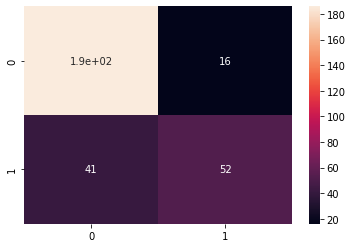

In [46]:
# If you want to evaluate the trainer run the code below

predictions = trainer.predict(test_ds)
output = np.argmax(predictions.predictions,1)
sns.heatmap(confusion_matrix(test.label.values,output),annot =confusion_matrix(test.label.values,output) )#,labels = ['1','-1','0']
plt.show()
del predictions #--> We delete the predictions as we don't want to occupy too much gpu space

In [ ]:
# averaged 'eval_f1': 0.7565478000260608 

In [47]:
# deleting all our objects to save GPU space
del model
del trainer
del train_ds
del val_ds
del test_ds
del tokenizer
torch.cuda.empty_cache()

## Defining the trainning arguments

In [48]:
# Try with finbert 
#  define tokenizer & model --> this is just a change from the previous code above
finbert_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

# turn the configuration for a 3 sentiment classification task
config = AutoConfig.from_pretrained("ProsusAI/finbert")
config.num_labels = 2

finbert_model = AutoModelForSequenceClassification.from_config(config)

# redefine our datasets as wechanged the tokenizer 

MAX_LEN = 128
train_ds = BERTTutorialDataset(
    input_data=train['sentence'].to_numpy(),
        sentiment_targets=train['label'].to_numpy(),
        tokenizer=finbert_tokenizer,
        max_len=MAX_LEN
    )
val_ds = BERTTutorialDataset(
    input_data=val['sentence'].to_numpy(),
        sentiment_targets=val['label'].to_numpy(),
        tokenizer=finbert_tokenizer,
        max_len=MAX_LEN
    )

test_ds = BERTTutorialDataset(
    input_data=test['sentence'].to_numpy(),
        sentiment_targets=test['label'].to_numpy(),
        tokenizer=finbert_tokenizer,
        max_len=MAX_LEN
    )


loading configuration file https://huggingface.co/ProsusAI/finbert/resolve/main/config.json from cache at C:\Users\drago/.cache\huggingface\transformers\2120f4f96b5830e5a91fe94d242471b0133b0976c8d6e081594ab837ac5f17bc.ef97278c578016c8bb785f15296476b12eae86423097fed78719d1c8197a3430
Model config BertConfig {
  "_name_or_path": "ProsusAI/finbert",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "positive",
    "1": "negative",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 1,
    "neutral": 2,
    "positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "ab

### Lauching the training preocess 

In [49]:
# Define trainning arguments 
training_args = TrainingArguments('FINBERT_TUTORIAL_MODEL', overwrite_output_dir=True, evaluation_strategy="steps", 
                                  num_train_epochs=50, weight_decay=1e-8,learning_rate=1e-5,
                                  eval_steps=50,metric_for_best_model='accuracy',
                                 per_device_train_batch_size=16, per_device_eval_batch_size=16,
                                 load_best_model_at_end = True, save_total_limit=10, save_steps=50,no_cuda=False,
                             fp16=True,gradient_accumulation_steps=4)
trainer = Trainer(
    model =finbert_model, args=training_args, train_dataset=train_ds, eval_dataset=val_ds,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=5)], compute_metrics=compute_metrics
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend


In [50]:
# If you want to run the trainer run the code below ( it takes about 10 minutes )

trainer.train()

***** Running training *****
  Num examples = 1376
  Num Epochs = 50
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 1050
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,No log,0.681930,0.628378,0.314189,0.500000,0.385892
100,No log,0.740371,0.628378,0.314189,0.500000,0.385892
150,No log,0.590951,0.706081,0.697631,0.710411,0.697800
200,No log,0.617572,0.719595,0.747031,0.641300,0.640266
250,No log,0.634409,0.753378,0.751161,0.703470,0.713022
300,No log,0.669219,0.729730,0.729730,0.745943,0.725201
350,No log,0.642477,0.743243,0.731047,0.743695,0.733712
400,No log,0.725971,0.750000,0.737905,0.750929,0.740720
450,No log,0.774906,0.780405,0.765193,0.762121,0.763564
500,0.340200,0.936976,0.783784,0.799241,0.731378,0.744552


***** Running Evaluation *****
  Num examples = 296
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to FINBERT_TUTORIAL_MODEL\checkpoint-50
Configuration saved in FINBERT_TUTORIAL_MODEL\checkpoint-50\config.json
Model weights saved in FINBERT_TUTORIAL_MODEL\checkpoint-50\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 296
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to FINBERT_TUTORIAL_MODEL\checkpoint-100
Configuration saved in FINBERT_TUTORIAL_MODEL\checkpoint-100\conf

TrainOutput(global_step=1050, training_loss=0.1994819956734067, metrics={'train_runtime': 928.5218, 'train_samples_per_second': 74.096, 'train_steps_per_second': 1.131, 'total_flos': 4523405263749120.0, 'train_loss': 0.1994819956734067, 'epoch': 49.98})

In [ ]:
trainer.evaluate(test_ds)

***** Running Evaluation *****
  Num examples = 295
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.


***** Running Prediction *****
  Num examples = 295
  Batch size = 16
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.


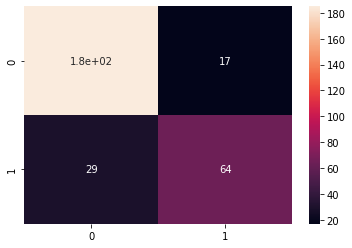

In [51]:
# If you want to evaluate the trainer run the code below


predictions = trainer.predict(test_ds)
output = np.argmax(predictions.predictions,1)
sns.heatmap(confusion_matrix(test.label.values,output),annot =confusion_matrix(test.label.values,output))
plt.show()
del predictions

In [61]:
precision =1.8e02/(1.8e02+29)
recall = 1.8e02/(1.8e02+17)
2*(precision*recall)/(precision+recall)

0.8866995073891625

In [52]:
# deleting all our objects to save GPU space
del finbert_model
del trainer
del train_ds
del val_ds
del test_ds
del finbert_tokenizer
torch.cuda.empty_cache()

# Masked Language Modelling code

In [53]:
# We will not be running the code below as it would take a long time

```python
# Import the model & tokenizer

model_to_pretrain = BertForMaskedLM.from_pretrained('bert-base-uncased')
tokenizer_for_pretraining = AutoTokenizer.from_pretrained("bert-base-cased")

# tokenize the inputs of the text 
inputs_for_pretraining = tokenizer_for_pretraining(df.sentence.tolist(), return_tensors='pt', max_length=32, truncation=True, padding='max_length')
inputs_for_pretraining['labels'] = inputs.input_ids.detach().clone()

# create random array of floats with equal dimensions to input_ids tensor
random_mask = torch.rand(inputs_for_pretraining.input_ids.shape)

# create mask array --> we hide 15% of the inputs for the masked language modelling task  
mask_arr = (random_mask < 0.15) * (inputs_for_pretraining.input_ids != 101) * \
           (inputs_for_pretraining.input_ids != 102) * (inputs_for_pretraining.input_ids != 0)

selection = []

for i in range(inputs_for_pretraining.input_ids.shape[0]):
    selection.append(
        torch.flatten(mask_arr[i].nonzero()).tolist()
    )
for i in range(inputs_for_pretraining.input_ids.shape[0]):
    inputs_for_pretraining.input_ids[i, selection[i]] = 103
    
    
class TUTORIALDataset(torch.utils.data.Dataset):
    """
    This is also a Dataset class as the Dataset class before 
    """
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)
    
    
dataset = TUTORIALDataset(inputs_for_pretraining)
loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Move model to device
model_to_pretrain.to(device)
# launch model training
model_to_pretrain.train()

args = TrainingArguments(
    output_dir='out',
    per_device_train_batch_size=16,
    num_train_epochs=2 #only 2 train epochs --> this is a safety check as this is a toy example, running a proper script with hyperparameters tuned for learning would take upwards of 10 hours ! 
)

MLM_trainer = Trainer(
    model=model_to_pretrain,
    args=args,
    train_dataset=dataset
)

MLM_trainer.train()
```

# 4. Visualisation

In [54]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers_interpret import SequenceClassificationExplainer

To visualise which words in each phrase are the most important for the prediction we will use the python package transformers_interpret 

In [55]:
fin_model_name = "ProsusAI/finbert"
model_name = "textattack/bert-base-uncased-SST-2"


fin_model = AutoModelForSequenceClassification.from_pretrained(fin_model_name)
fin_tokenizer = AutoTokenizer.from_pretrained(fin_model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

loading configuration file https://huggingface.co/ProsusAI/finbert/resolve/main/config.json from cache at C:\Users\drago/.cache\huggingface\transformers\2120f4f96b5830e5a91fe94d242471b0133b0976c8d6e081594ab837ac5f17bc.ef97278c578016c8bb785f15296476b12eae86423097fed78719d1c8197a3430
Model config BertConfig {
  "_name_or_path": "ProsusAI/finbert",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "positive",
    "1": "negative",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 1,
    "neutral": 2,
    "positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "ab

In [56]:
# With both the model and tokenizer initialized we are now able to get explanations on an example text.
cls_explainer = SequenceClassificationExplainer(model,
                                                tokenizer)

fin_cls_explainer = SequenceClassificationExplainer(fin_model,
                                                    fin_tokenizer)

In [57]:
word_attributions = cls_explainer("Pharmaceuticals group Orion Corp reported a fall in its third-quarter earnings that were hit by larger expenditures on R&D and marketing")
word_attributions = fin_cls_explainer("Pharmaceuticals group Orion Corp reported a fall in its third-quarter earnings that were hit by larger expenditures on R&D and marketing")

In [58]:
cls_explainer.predicted_class_name

'LABEL_0'

In [59]:
bert_vis = cls_explainer.visualize()

In [60]:
fin_bert_vis = fin_cls_explainer.visualize()

# In summary 

| **Model name**        | **Loughram McDonald** | **Naive Bayes** | **Bert** | **FinBert** |
|-----------------------|-----------------------|-----------------|----------|-------------|
| **Averaged F1 Score** | 0.2544                | 0.3954          | 0.7564   |    0.8866   |
